In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install fastai2 torchviz

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.4/179.4 kB 4.6 MB/s eta 0:00:00a 0:00:01
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=f576cb2fa20fc257de7d9119e3acc3cee93feef8a9fcfc743c841cb46cc06bc3
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [3]:
!pip install -q efficientnet_pytorch

In [4]:
import os
import torch
import random
import pandas as pd
import numpy as np
import cv2

from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
from efficientnet_pytorch import EfficientNet
import torchvision.transforms.functional as TF

%matplotlib inline

In [5]:
DATA_DIR = '/kaggle/input/jovian-pytorch-z2g/Human protein atlas'



TRAIN_DIR = DATA_DIR + '/train'                           # Contains training images
TEST_DIR = DATA_DIR + '/test'                             # Contains test images

TRAIN_CSV = DATA_DIR + '/train.csv'  


TEST_CSV = DATA_DIR + '/train.csv'   

In [6]:
!head "{TRAIN_CSV}"

Image,Label
19567,9
29993,6 4
17186,1 4
29600,6 2
701,3 4
26562,9
1080,4
27886,4
30721,6


In [7]:
!head "{TEST_CSV}"

Image,Label
19567,9
29993,6 4
17186,1 4
29600,6 2
701,3 4
26562,9
1080,4
27886,4
30721,6


In [8]:
!ls "{TRAIN_DIR}" | head

0.png
1.png
10000.png
10001.png
10005.png
10008.png
10009.png
10012.png
10013.png
10014.png
ls: write error: Broken pipe


In [9]:
train_df = pd.read_csv(TRAIN_CSV)
train_df.head()

,Image,Label
0,19567,9
1,29993,6 4
2,17186,1 4
3,29600,6 2
4,701,3 4


In [10]:
labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

In [11]:
def encode_label(label):
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

In [12]:
encode_label('2 4 5')

tensor([0., 0., 1., 0., 1., 1., 0., 0., 0., 0.])

In [13]:
decode_target(torch.tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 0.]))

'2 4 5'

In [14]:
decode_target(torch.tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 0.]), text_labels=True)

'Nucleoli(2) Nucleoplasm(4) Nucleoli fibrillar center(5)'

In [15]:
class HumanProteinDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
#         self.df = pd.read_csv(csv_file) 
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['Image'], row['Label']
        img_fname = self.root_dir + "/" + str(img_id) + ".png"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label)

In [16]:
# --- Read in Data ---

val_pct = 0.1
val_size = int(val_pct * len(train_df))
train_size = len(train_df) - val_size

start_step = 8000
valid_data = train_df.iloc[start_step:start_step+val_size].reset_index(drop=True)
train_data = pd.concat([train_df.iloc[:start_step], train_df.iloc[start_step+val_size:]]).reset_index(drop=True)

len(train_data), len(valid_data)


(17313, 1923)

In [17]:
train_transform = transforms.Compose([  
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, saturation=0.2, contrast=0.2),
    transforms.ToTensor()
    ])

test_transform = transforms.Compose([
    transforms.ToTensor()

    ])

train_ds = HumanProteinDataset(train_data, TRAIN_DIR, transform=train_transform)
val_ds = HumanProteinDataset(valid_data, TRAIN_DIR, transform=test_transform)

In [18]:
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True))

Labels: Nuclear speckles(9)


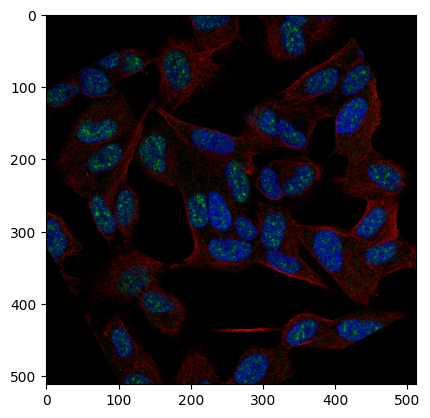

In [19]:
show_sample(*train_ds[0], invert=False)

Labels: Nuclear speckles(9)


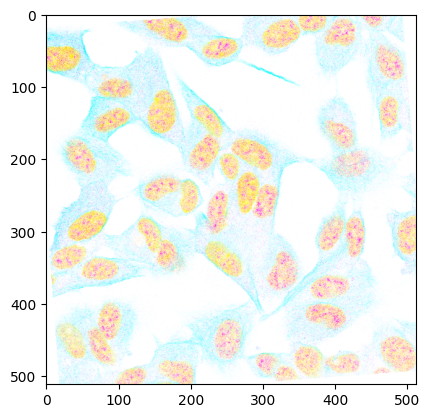

In [20]:
show_sample(*train_ds[0])

In [21]:
torch.manual_seed(10)

In [22]:
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

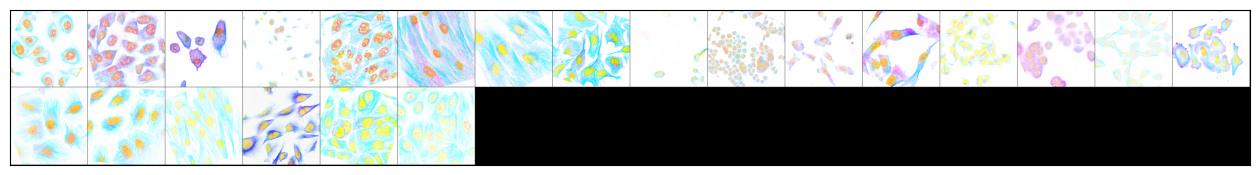

In [23]:
batch_size = 22

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

show_batch(train_dl)

In [24]:
precision_global = None
recall_global = None

In [25]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold
    
    global precision_global, recall_global
    
    
    

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    
    precision_global = precision
    recall_gobal = recall
    
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [26]:
ALPHA = 0.25
GAMMA = 2
FOCAL_LOSS = False

class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)      
        
        loss = F.binary_cross_entropy(out, targets)
        bce_exp = torch.exp(-loss)
        focal_loss = ALPHA * (1-bce_exp)**GAMMA * loss
        if FOCAL_LOSS: loss = focal_loss
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images) 
        # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        bce_exp = torch.exp(-loss)
        focal_loss = ALPHA * (1-bce_exp)**GAMMA * loss
        
        score = F_score(out, targets)
        if FOCAL_LOSS: loss = focal_loss
            
        return {'val_loss': loss.detach(), 'val_score': score.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_score']))

In [27]:
class EfficientNetwork(MultilabelImageClassificationBase):
    def __init__(self, b4=False, b2=False):
        super().__init__()
        self.b4, self.b2 = b4, b2
        
        # Define Feature part
        if b4:
            self.features = EfficientNet.from_pretrained('efficientnet-b4')
        elif b2:
            self.features = EfficientNet.from_pretrained('efficientnet-b2')
        else:
            self.features = EfficientNet.from_pretrained('efficientnet-b1')
        
        # Define Classification part
        if b4:
            self.classification = nn.Linear(1792, 10)
        elif b2:
            self.classification = nn.Linear(1408, 10)
        else:
            self.classification = nn.Linear(1280, 10)
        
        
    def forward(self, image, prints=False):
        if prints: print('Input Image shape:', image.shape)
        
        image = self.features.extract_features(image)
        if prints: print('Features Image shape:', image.shape)
            
        if self.b4:
            image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1792)
        elif self.b2:
            image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1408)
        else:
            image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1280)
        if prints: print('Image Reshaped shape:', image.shape)
        
        out = self.classification(image)
        if prints: print('Out shape:', out.shape)
        
        return torch.sigmoid(out)
    
    

In [28]:
  class Resnet(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [29]:
model = EfficientNetwork(b4=False, b2=False)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 65.3MB/s]


Loaded pretrained weights for efficientnet-b1


In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

7806994

In [31]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [32]:
device = get_default_device()
device

device(type='cuda')

In [33]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [34]:
def try_batch(dl):
    for images, labels in dl:
        print('images.shape:', images.shape)
        out = model(images)
        print('out.shape:', out.shape)
        print('out[0]:', out[0])
        break

try_batch(train_dl)

images.shape: torch.Size([22, 3, 512, 512])
out.shape: torch.Size([22, 10])
out[0]: tensor([0.5320, 0.5168, 0.4496, 0.4842, 0.5510, 0.5080, 0.5127, 0.4707, 0.4918,
        0.5035], device='cuda:0', grad_fn=<SelectBackward0>)


In [35]:
from tqdm.notebook import tqdm

In [36]:
num_epochs = 20

es_patience = 5

opt_func = torch.optim.AdamW
lr_patience = 2
lr_factor = 0.2
max_lr = 0.01
lr = 0.0001

weight_decay = 0.01
amsgrad=True

In [37]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, lr, max_lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    lrs = []
    valid_loss_min = np.Inf
    model_file_name = 'best_model.pth'
    epochs_no_improve =  0
    
    optimizer = opt_func(model.parameters(), lr=lr, amsgrad=True, weight_decay=weight_decay)
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(train_loader), epochs=epochs)
#     scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=2)

    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            
            lrs.append(get_lr(optimizer))
      # Validation phase   

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs

        valid_loss = result['val_loss']


        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), model_file_name)
            valid_loss_min = valid_loss                                  
            epochs_no_improve = 0          
        else:
            epochs_no_improve += 1
            if epochs_no_improve > es_patience:
                model.epoch_end(epoch, result)
                history.append(result)
                return history  
               
        
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [38]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 0.6997451782226562, 'val_score': 0.1551237404346466}]

In [39]:
%%time
### After all the epochs end, load best_model.pth, reduce learning to 0.00001 and train a little more
history = fit(num_epochs, lr, max_lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/787 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.2576, val_loss: 0.2512, val_score: 0.6581


  0%|          | 0/787 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.2272, val_loss: 0.2884, val_score: 0.6460


  0%|          | 0/787 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.2272, val_loss: 0.2531, val_score: 0.6499


  0%|          | 0/787 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.2266, val_loss: 0.2596, val_score: 0.5801


  0%|          | 0/787 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.2215, val_loss: 0.2708, val_score: 0.6125


  0%|          | 0/787 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.2162, val_loss: 0.2533, val_score: 0.6229


  0%|          | 0/787 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.2115, val_loss: 0.2231, val_score: 0.6642


  0%|          | 0/787 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.2057, val_loss: 0.2143, val_score: 0.6997


  0%|          | 0/787 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.2021, val_loss: 0.2401, val_score: 0.6118


  0%|          | 0/787 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.1963, val_loss: 0.2054, val_score: 0.7075


  0%|          | 0/787 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.1921, val_loss: 0.2466, val_score: 0.6465


  0%|          | 0/787 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.1880, val_loss: 0.2111, val_score: 0.6821


  0%|          | 0/787 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.1823, val_loss: 0.1919, val_score: 0.7189


  0%|          | 0/787 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.1757, val_loss: 0.1814, val_score: 0.7592


  0%|          | 0/787 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.1693, val_loss: 0.1674, val_score: 0.7785


  0%|          | 0/787 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.1634, val_loss: 0.1581, val_score: 0.8020


  0%|          | 0/787 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.1562, val_loss: 0.1568, val_score: 0.8012


  0%|          | 0/787 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.1495, val_loss: 0.1504, val_score: 0.8204


  0%|          | 0/787 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.1443, val_loss: 0.1495, val_score: 0.8198


  0%|          | 0/787 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.1412, val_loss: 0.1490, val_score: 0.8219
CPU times: user 1h 39min 25s, sys: 1h 6min 59s, total: 2h 46min 25s
Wall time: 2h 41min 22s


In [40]:
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [41]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');

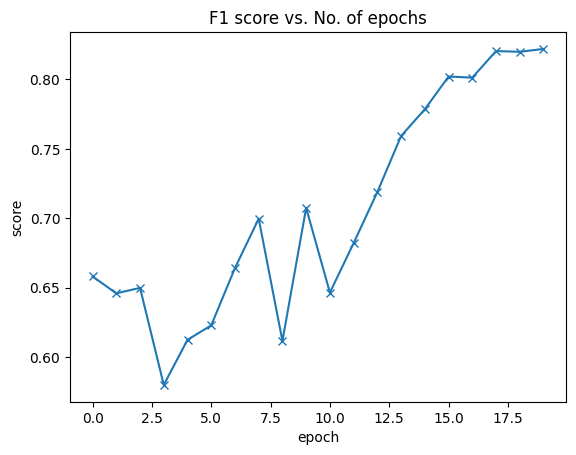

In [42]:
plot_scores(history)

In [43]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    show_sample(image, prediction)

In [44]:
test_data = pd.read_csv(TRAIN_CSV)
TEST_DIR = DATA_DIR + '/train'
test_dataset = HumanProteinDataset(test_data, TEST_DIR, transform=test_transform)

In [45]:
img, target = test_dataset[0]
img.shape

torch.Size([3, 512, 512])

Prediction:  tensor([1.1182e-04, 6.6568e-04, 9.5140e-01, 5.4113e-05, 1.8544e-03, 4.6928e-02,
        2.7037e-04, 6.8627e-04, 1.4750e-04, 5.1440e-04], device='cuda:0',
       grad_fn=<SelectBackward0>)
Labels: Nucleoli(2)


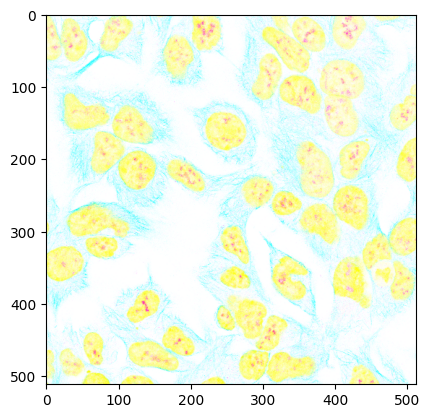

In [46]:
predict_single(test_dataset[100][0])

Prediction:  tensor([0.0099, 0.0037, 0.3369, 0.0035, 0.9885, 0.0170, 0.0502, 0.0111, 0.0053,
        0.0018], device='cuda:0', grad_fn=<SelectBackward0>)
Labels: Nucleoplasm(4)


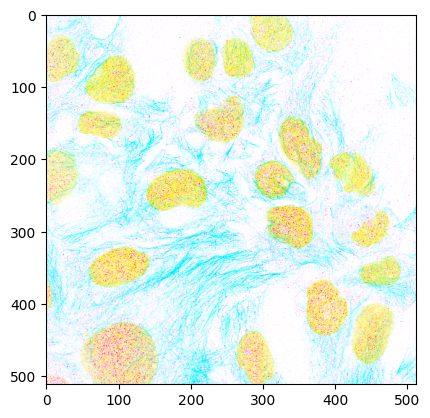

In [ ]:
predict_single(test_dataset[74][0])

In [ ]:
test_dl = DeviceDataLoader(DataLoader(test_dataset, batch_size*4, num_workers=2, pin_memory=True), device)

In [ ]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)      
    return [decode_target(x) for x in batch_probs]

In [50]:
test_preds = predict_dl(test_dl, model)

  0%|          | 0/219 [00:00<?, ?it/s]

In [51]:
len(test_preds)

19236

In [52]:
submission_df = pd.read_csv(TRAIN_CSV)

In [53]:
len(test_preds)

19236

In [54]:
submission_df['Pred'] = test_preds

In [55]:
submission_df

,Image,Label,Pred
0,19567,9,9
1,29993,6 4,4 6
2,17186,1 4,3 4
3,29600,6 2,2 6
4,701,3 4,3 4
...,...,...,...
19231,428,6,6 7
19232,5342,6 7,7
19233,9806,4,4
19234,16112,5,5


In [56]:
submission_df.to_csv('EfficientNet_Pred.csv', index=False)

In [57]:
import pandas as pd

# Load the data into a pandas DataFrame
data = submission_df  # Replace 'file_path.csv' with the path to your file
# Assuming your columns are named 'predicted' and 'test'
predicted_labels = data['Pred'].apply(lambda x: set(x.split(',')))
test_labels = data['Label'].apply(lambda x: set(x.split(',')))

# Calculate accuracy
correct_predictions = 0
total_predictions = len(data)

for pred, test in zip(predicted_labels, test_labels):
    if pred == test:
        correct_predictions += 1

accuracy = correct_predictions / total_predictions
print("Accuracy:", accuracy)


Accuracy: 0.5289041380744437


Prediction:  tensor([0.0019, 0.0030, 0.9773, 0.0783, 0.1964, 0.0076, 0.8096, 0.2087, 0.0072,
        0.0020], device='cuda:0', grad_fn=<SelectBackward0>)
Labels: Nucleoli(2) Cytosol(6)
None


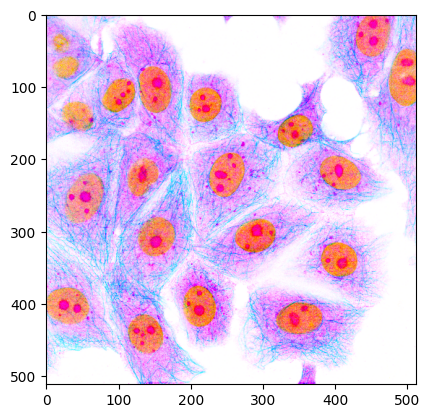

In [58]:
print(predict_single(test_dataset[3][0]))

In [59]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

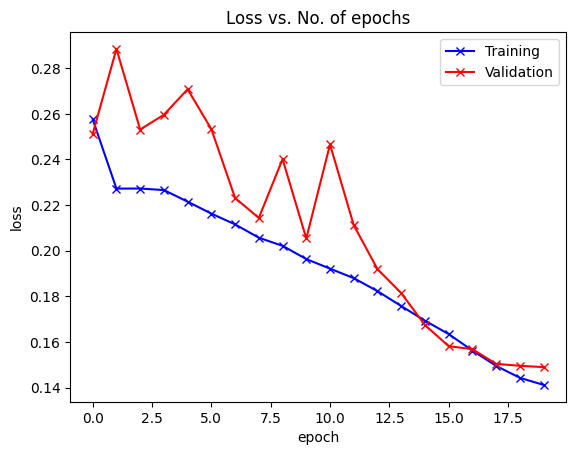

In [60]:
plot_losses(history)